In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_vector_field(grid, displacement):
    x = grid[:, 0].numpy()
    y = grid[:, 1].numpy()
    u = displacement[:, 0].numpy()
    v = displacement[:, 1].numpy()

    plt.figure(figsize=(5, 5))

    # color the vector field based on the magnitude of the displacement
    magnitude = np.sqrt(u**2 + v**2)
    plt.quiver(x, y, u, v, magnitude, cmap='viridis',
               angles='xy', scale_units='xy', scale=1, alpha=0.5)
    
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(np.min(y), np.max(y))
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Vector Field')
    plt.grid()
    plt.show()

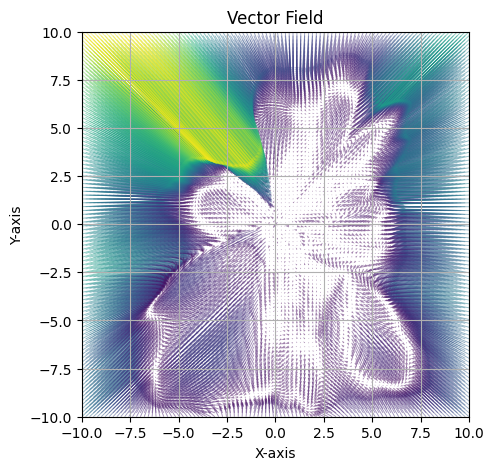

In [3]:
vfield = torch.load('data/vectorfield.pt')
grid = vfield['grid']
displacement=vfield['displacement']

plot_vector_field(grid, displacement)


generate lics: 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]

generate lics: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]



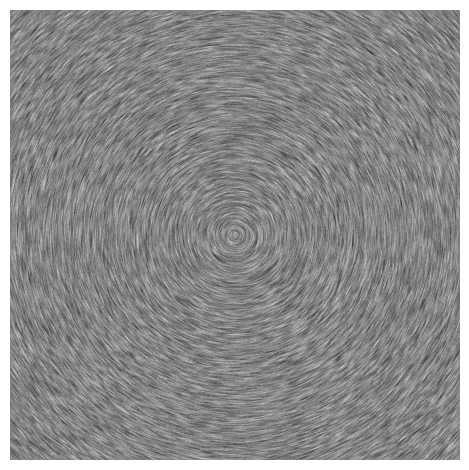

In [4]:
import numpy as np
import lic, matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. analytic test field – a clockwise vortex centred at (0,0)
# ---------------------------------------------------------
R = 1.6          # extent; bigger = more turns visible
RES = 1024       # square output resolution

# pixel grid in [-R, R] coordinates
x, y = np.mgrid[-R:R:RES*1j, -R:R:RES*1j]
u = -y                            # vx = -y   (curl field)
v =  x                            # vy =  x

# ---------------------------------------------------------
# 2. normalise the field so every vector has length 1
#    (prevents areas of strong/weak magnitude dominating)
# ---------------------------------------------------------
mag = np.hypot(u, v)
u /= mag + 1e-9
v /= mag + 1e-9

# ---------------------------------------------------------
# 3. run LIC – seed texture created for you by lic.gen_seed
# ---------------------------------------------------------
seed = lic.gen_seed((RES, RES), noise="white")     # white noise, float32 in [0,1]
lic_img = lic.lic(u, v, seed, length=30)

# ---------------------------------------------------------
# 4. display – turn off axes so you just see the texture
# ---------------------------------------------------------
plt.imshow(lic_img, cmap='gray', origin='lower')
plt.axis('off'); plt.tight_layout(); plt.show()


In [5]:
import numpy as np
from PIL import Image, ImageDraw

# ------------- parameters -------------
W, H      = 4000, 4000          # canvas size
N_PART    = 10_000             # more particles = denser texture
STEPS     = 400                 # integration steps per particle
STEP_SIZE = 0.002               # ~ fraction of image width
ALPHA     = 2                   # 0-255 per stroke
BG        = 255                 # white background

# ------------- vector field -----------
def F(px, py):
    """Example: curl of Perlin-ish noise field (here a simple swirl)"""
    # map pixel → [-1,1] coords
    x = (px/W)*2 - 1
    y = (py/H)*2 - 1
    return -y, x      # simple vortex

# ------------- integrate --------------
img = Image.new("L", (W, H), BG)
drw = ImageDraw.Draw(img, "L")

rng = np.random.default_rng(0)
starts_x = rng.uniform(0, W,  N_PART)
starts_y = rng.uniform(0, H,  N_PART)

for x0, y0 in zip(starts_x, starts_y):
    x, y = x0, y0
    pts   = []
    for _ in range(STEPS):
        u, v = F(x, y)
        norm = (u*u + v*v)**0.5 + 1e-6
        x   += (u / norm) * STEP_SIZE * W
        y   += (v / norm) * STEP_SIZE * W
        if not (0 <= x < W and 0 <= y < H):
            break
        pts.append((x, y))
    if len(pts) > 1:
        drw.line(pts, fill=BG-ALPHA, width=1)   # low-alpha, additive

# img = img.filter(Image.BLUR)  # subtle blur like the example
img.save("flow_field.png")

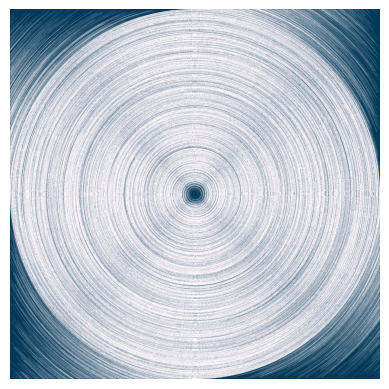

In [6]:
plt.imshow(img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.show()